# (07) Align (across) -- results

**Motivation**: Alignment scores across model classes only. Load and plot results for both lasso and permutation importance. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
_PROPS = {
    'meanprops': {
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'k',
        'markersize': 3,
        'alpha': 1.0},
    'flierprops': {
        'marker': 'o',
        'markersize': 1.5,
        'alpha': 0.3,
        'zorder': 1},
    'showfliers': True,
    'showmeans': True,
    'dodge': True,
    'width': 0.7,
}

## Setup

In [3]:
fig_dir = pjoin(fig_base_dir, 'rebuttal_aug')
print(fig_dir)

path = pjoin(tmp_dir, 'alignment_rebuttal')
pal_model, pal_cat = get_palette()

/home/hadi/Dropbox/git/jb-MTMST/figs/rebuttal_aug

In [4]:
betas = [
    0.001, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6,
    0.7, 0.8, 0.9, 1.0, 2.0, 1.5, 5.0, 10.0,
]  
thres = 0.1

## Lasso

### Load

In [5]:
df = []
for b in betas:
    fwd = f'lasso_src-cNVAE_tgt-VAE_beta-{b}.npy'
    bwd = f'lasso_src-VAE_tgt-cNVAE_beta-{b}.npy'
    fwd = np.load(pjoin(path, fwd), allow_pickle=True).item()
    bwd = np.load(pjoin(path, bwd), allow_pickle=True).item()

    # num = min(
    #    sum(fwd['kl_tgt'] > thres),
    #    sum(bwd['kl_tgt'] > thres),
    # )
    for d in [fwd, bwd]:
        # ids = np.argsort(d['kl_tgt'])[::-1][:num]
        for k in ['a', 'r2']:
            cond = ' -> '.join([
                d['metadata']['model_src'],
                d['metadata']['model_tgt'],
            ])
            v = d[k] # [ids],
            df.append({
                'beta': [b] * len(v),
                'cond': [cond] * len(v),
                'measure': [k] * len(v),
                'value': v, 
            })
df = pd.DataFrame(merge_dicts(df))

### Plot

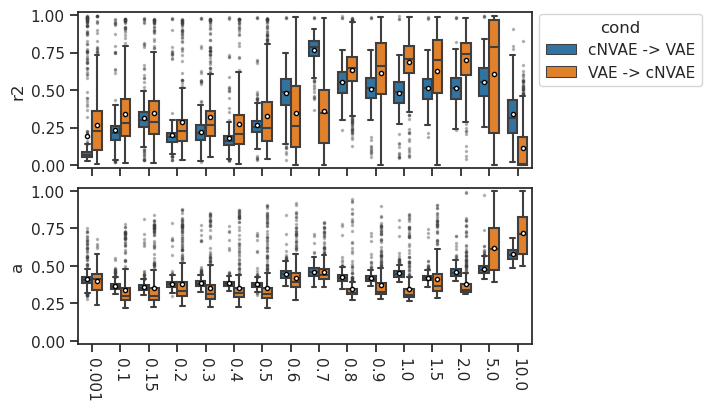

In [6]:
fig, axes = create_figure(2, 1, (7, 4.0), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    _df = df.loc[df['measure'] == k]
    ax = axes.flat[i]
    sns.boxplot(
        data=_df,
        x='beta',
        y='value',
        hue='cond',
        ax=ax,
        **_PROPS,
    )
    ax.set_ylabel(k)
    ax.set(
        xlabel='',
        ylim=(-0.02, 1.02),
    )
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        leg.set_bbox_to_anchor((1, 1.04))
    # ax.grid(axis='both')
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

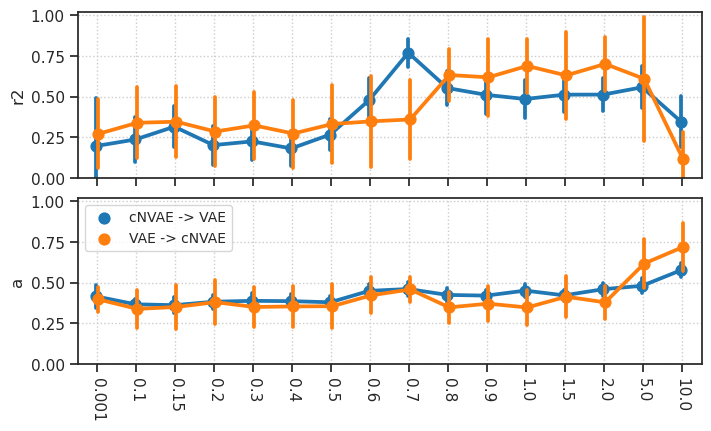

In [7]:
fig, axes = create_figure(2, 1, (7, 4.2), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    _df = df.loc[df['measure'] == k]
    ax = axes.flat[i]
    sns.pointplot(
        data=_df,
        x='beta',
        y='value',
        hue='cond',
        errorbar='sd',
        dodge=True,
        ax=ax,
    )
    ax.set_ylabel(k)
    ax.set(
        xlabel='',
        ylim=(0, 1.02),
    )
    leg = ax.get_legend()
    if i == 0:
        leg.remove()
    else:
        sns.move_legend(ax, 'best', fontsize=10, title='')
    ax.grid()
    # else:
        # leg.set_bbox_to_anchor((1, 1.03))
axes[-1].tick_params(axis='x', rotation=-90)

### $t-$test

In [8]:
for b in sorted(sorted(df['beta'].unique())):
    _df = df.loc[
        (df['beta'] == b) &
        (df['measure'] == 'a')
    ]
    a1 = _df.loc[_df['cond'] == 'cNVAE -> VAE', 'value'].values
    a2 = _df.loc[_df['cond'] == 'VAE -> cNVAE', 'value'].values
    good = np.isfinite(a1) & np.isfinite(a2)
    t = sp_stats.ttest_ind(
        a=a1[good],
        b=a2[good],
        equal_var=False,
    )
    print(b, t)

0.001
Ttest_indResult(statistic=3.5519031277680577, pvalue=0.00040398654773014206)

0.1
Ttest_indResult(statistic=4.81747576128504, pvalue=1.9496189332654926e-06)

0.15
Ttest_indResult(statistic=1.6200922136161504, pvalue=0.10581339041891269)

0.2
Ttest_indResult(statistic=0.3910525168051898, pvalue=0.6959236933772461)

0.3
Ttest_indResult(statistic=6.0214115319219434, pvalue=3.1994694098885957e-09)

0.4
Ttest_indResult(statistic=5.044390851183139, pvalue=6.31139945584247e-07)

0.5
Ttest_indResult(statistic=3.5293032670852216, pvalue=0.00045539675877218246)

0.6
Ttest_indResult(statistic=4.7584324024703415, pvalue=2.501163826424727e-06)

0.7
Ttest_indResult(statistic=0.6312095688183423, pvalue=0.5281195450967386)

0.8
Ttest_indResult(statistic=15.1349477918173, pvalue=9.836532107346975e-44)

0.9
Ttest_indResult(statistic=8.81526992190474, pvalue=1.969759298247015e-17)

1.0
Ttest_indResult(statistic=18.5969768102976, pvalue=1.1276857342005468e-59)

1.5
Ttest_indResult(statistic=1.2413529894690454, pvalue=0.2150960390940964)

2.0
Ttest_indResult(statistic=15.388204356924778, pvalue=1.2635581038685603e-44)

5.0
Ttest_indResult(statistic=-17.17045975902234, pvalue=3.836863339600754e-51)

10.0
Ttest_indResult(statistic=-14.059847983340516, pvalue=7.892856482506891e-34)

### Plot subset of betas

In [9]:
selected_betas = [0.2, 0.5, 1.0, 5.0]
d2p = df.loc[df['beta'].isin(selected_betas)]

In [10]:
for b in selected_betas:
    _df = df.loc[
        (df['beta'] == b) &
        (df['measure'] == 'a')
    ]
    a1 = _df.loc[_df['cond'] == 'cNVAE -> VAE', 'value'].values
    a2 = _df.loc[_df['cond'] == 'VAE -> cNVAE', 'value'].values
    good = np.isfinite(a1) & np.isfinite(a2)
    t = sp_stats.ttest_ind(
        a=a1[good],
        b=a2[good],
        equal_var=False,
    )
    print(b, t)

0.2
Ttest_indResult(statistic=0.3910525168051898, pvalue=0.6959236933772461)

0.5
Ttest_indResult(statistic=3.5293032670852216, pvalue=0.00045539675877218246)

1.0
Ttest_indResult(statistic=18.5969768102976, pvalue=1.1276857342005468e-59)

5.0
Ttest_indResult(statistic=-17.17045975902234, pvalue=3.836863339600754e-51)

#### Box

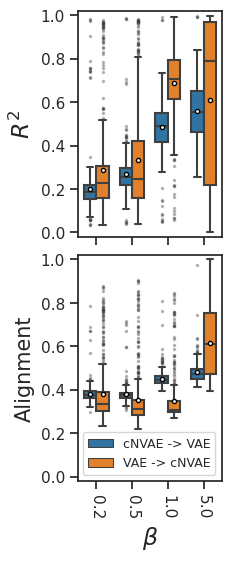

In [18]:
fig, axes = create_figure(2, 1, (2.2, 5.5), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    _df = d2p.loc[d2p['measure'] == k]
    ax = axes.flat[i]
    sns.boxplot(
        data=_df,
        x='beta',
        y='value',
        hue='cond',
        ax=ax,
        **_PROPS,
    )
    ax.set_ylabel(k)
    ax.set(
        xlabel='',
        ylim=(-0.02, 1.02),
    )
    leg = ax.get_legend()
    if i == 0:
        leg.remove()
    else:
        sns.move_legend(
            obj=ax,
            loc='lower right',
            fontsize=9,
            title='',
        )
    # leg.set_bbox_to_anchor((1, 1.03))
    # ax.grid(axis='both')
axes[0].set_ylabel(r"$R^2$", fontsize=17)
axes[1].set_ylabel('Alignment', fontsize=15)
axes[1].set_xlabel(r"$\beta$", fontsize=17)
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

#### Pointplot

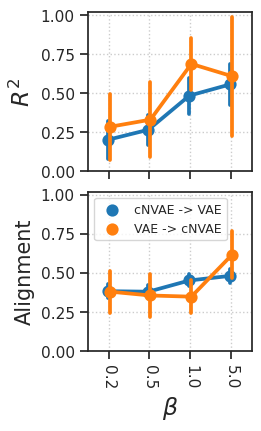

In [21]:
fig, axes = create_figure(2, 1, (2.5, 4.2), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    _df = d2p.loc[d2p['measure'] == k]
    ax = axes.flat[i]
    sns.pointplot(
        data=_df,
        x='beta',
        y='value',
        hue='cond',
        errorbar='sd',
        dodge=True,
        ax=ax,
    )
    ax.set_ylabel(k)
    ax.set(
        xlabel='',
        ylim=(0, 1.02),
    )
    leg = ax.get_legend()
    if i == 0:
        leg.remove()
    else:
        sns.move_legend(
            obj=ax,
            loc='best',
            fontsize=9,
            title='',
        )
    ax.grid()
    # else:
        # leg.set_bbox_to_anchor((1, 1.03))
axes[0].set_ylabel(r"$R^2$", fontsize=17)
axes[1].set_ylabel('Alignment', fontsize=15)
axes[1].set_xlabel(r"$\beta$", fontsize=17)
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

## Perm

### Load

In [8]:
df = []
for b in betas:
    if b not in [0.15, 0.2, 0.3, 0.4, 0.5, 1.0]:
        continue
    
    fwd = f'src-cNVAE_tgt-VAE_beta-{b}.npy'
    bwd = f'src-VAE_tgt-cNVAE_beta-{b}.npy'
    fwd = np.load(pjoin(path, fwd), allow_pickle=True).item()
    bwd = np.load(pjoin(path, bwd), allow_pickle=True).item()

    num = min(
        sum(fwd['kl_tgt'] > thres),
        sum(bwd['kl_tgt'] > thres),
    )
    for d in [fwd, bwd]:
        # ids = np.argsort(d['kl_tgt'])[::-1][:num]
        for k in ['a', 'r2']:
            cond = ' -> '.join([
                d['metadata']['model_src'],
                d['metadata']['model_tgt'],
            ])
            v = d[k] # [ids]
            df.append({
                'beta': [b] * len(v),
                'cond': [cond] * len(v),
                'measure': [k] * len(v),
                'value': v, 
            })
df = pd.DataFrame(merge_dicts(df))

### Plot

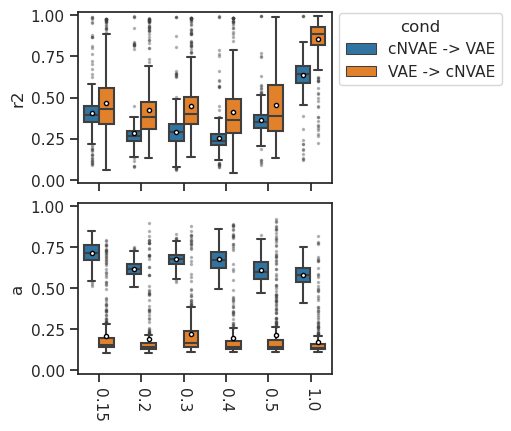

In [9]:
fig, axes = create_figure(2, 1, (5, 4.2), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    _df = df.loc[df['measure'] == k]
    ax = axes.flat[i]
    sns.boxplot(
        data=_df,
        x='beta',
        y='value',
        hue='cond',
        ax=ax,
        **_PROPS,
    )
    ax.set_ylabel(k)
    ax.set(
        xlabel='',
        ylim=(-0.02, 1.02),
    )
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        leg.set_bbox_to_anchor((1, 1.04))

axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

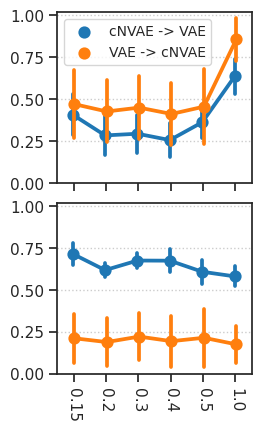

In [10]:
fig, axes = create_figure(2, 1, (2.5, 4.2), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    _df = df.loc[df['measure'] == k]
    ax = axes.flat[i]
    ax.set_ylabel(k)
    ax.grid()
    sns.pointplot(
        data=_df,
        x='beta',
        y='value',
        hue='cond',
        errorbar='sd',
        dodge=True,
        ax=ax,
    )
    ax.set(
        xlabel='',
        ylabel='',
        ylim=(0, 1.02),
    )
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        sns.move_legend(ax, 'best', fontsize=10, title='')
    # else:
        # leg.set_bbox_to_anchor((1, 1.03))
axes[-1].tick_params(axis='x', rotation=-90)